In [1]:
from combustion import CombustionStage, SundialsChemicalIntegrator, SundialsIntegratorConfig
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
import time
from enum import Enum
from typing import Dict, Any, List, Optional, Tuple
import SundialsPy  # Your SUNDIALS wrapper
from tqdm import tqdm
from environment.combustion_problem import CombustionProblem, setup_problem
import os 
import rk_solver_cpp

In [2]:
mechanism = "large_mechanism/ch4_53species.yaml"
fuel = "CH4"

In [3]:
# Core Problem Class
class CombustionProblem:
    """Defines and manages a combustion problem including reference solution computation."""

    def __init__(self, 
                 mech_file: str,
                 temperature: float,
                 pressure: float,
                 phi: float,
                 fuel: str = 'CH4',
                 oxidizer: str = 'O2:1, N2:3.76',
                 end_time: float = 1e-3,
                 timestep: float = 1e-6,
                 species_to_track: Optional[List[str]] = None,
                 initial_mixture: str = None,
                 reference_rtol: float = 1e-10,
                 reference_atol: float = 1e-20,
                 state_change_threshold: float = 1,
                 normalizing_temperature: float = 1000,
                 verbose: bool = True
                 ):
        """Initialize combustion problem."""
        self._initialize_parameters(locals())
        self._setup_cantera()
        self._initialize_tracking()
        if self.verbose:
            print(f"Combustion problem initialized with T={self.temperature}, P={self.pressure}, phi={self.phi} and timestep={self.timestep}")
        self._compute_reference_solution()

    def _initialize_parameters(self, params):
        """Initialize all parameters from constructor."""
        for key, value in params.items():
            if key != 'self':
                setattr(self, key, value)
        self.num_steps = int(self.end_time / self.timestep)
        self.ignition_delay = 0.0
        self.reference_solution = None
        self.current_state = CombustionStage.PREIGNITION

    def _setup_cantera(self):
        """Initialize Cantera solution and mixture."""
        try:
            self.gas = ct.Solution(self.mech_file)
            if self.initial_mixture is None:
                self.initial_mixture = f"{self.fuel}:1, {self.oxidizer}"
            self.gas.set_equivalence_ratio(self.phi, self.fuel, self.oxidizer)
            self.gas.TPX = self.temperature, self.pressure, self.initial_mixture
        except Exception as e:
            print(f"Error in Cantera setup: {e}")
            raise e

    def _initialize_tracking(self):
        """Initialize species tracking."""
        if self.species_to_track is None:
            self.species_to_track = ['H2', 'O2', 'H', 'OH', 'H2O', 'HO2', 'H2O2']

    def _state_changed_significantly(self, previous_state, current_state):
        """Check if state change is significant."""
        previous_state = np.array(previous_state) if isinstance(previous_state, list) else previous_state
        current_state = np.array(current_state) if isinstance(current_state, list) else current_state
        state_change = np.linalg.norm(current_state - previous_state)
        return state_change > self.state_change_threshold, state_change

    def _compute_reference_solution(self) -> None:
        """Compute reference solution using Cantera."""
        reactor = ct.IdealGasConstPressureReactor(self.gas)
        sim = ct.ReactorNet([reactor])
        sim.rtol, sim.atol = self.reference_rtol, self.reference_atol

        results = self._run_simulation(reactor, sim)
        self._store_reference_solution(results)

    def _run_simulation(self, reactor, sim):
        """Run the actual simulation."""
        times = np.zeros(self.num_steps)
        temperatures = np.zeros(self.num_steps)
        pressures = np.zeros(self.num_steps)
        species_profiles = {spec: np.zeros(self.num_steps) for spec in self.species_to_track}
        
        start_time = time.time()
        stage_steps = {stage: 0 for stage in CombustionStage}
        stage_changes = [False]
        
        for i in tqdm(range(self.num_steps), desc="Computing reference solution", disable=not self.verbose):
            if not self._process_simulation_step(i, reactor, sim, times, temperatures, pressures, species_profiles, stage_steps, stage_changes):
                break
                
        return {
            'times': times,
            'temperatures': temperatures,
            'pressures': pressures,
            'species_profiles': species_profiles,
            'computation_time': time.time() - start_time,
            'completed_steps': i
        }

    def _process_simulation_step(self, i, reactor, sim, times, temperatures, pressures, species_profiles, stage_steps, stage_changes):
        """Process a single simulation step."""
        previous_state = reactor.thermo.state
        t = i * self.timestep
        sim.advance(t)
        
        # Record data
        times[i] = t
        temperatures[i] = reactor.T
        pressures[i] = reactor.thermo.P
        for spec in self.species_to_track:
            species_profiles[spec][i] = reactor.thermo[spec].Y
            
        # Check state changes
        state_changed, state_change = self._state_changed_significantly(previous_state, reactor.thermo.state)
        stage_changes.append(state_changed)
        
        return self._handle_stage_transitions(i, stage_changes, stage_steps)

    def _handle_stage_transitions(self, i, stage_changes, stage_steps):
        """Handle transitions between combustion stages."""
        if stage_changes[-1] != stage_changes[-2]:
            if self.current_state == CombustionStage.PREIGNITION:
                stage_steps[self.current_state] = i
                self.current_state = CombustionStage.IGNITION
                self.ignition_delay = i * self.timestep
            elif self.current_state == CombustionStage.IGNITION:
                stage_steps[self.current_state] = i
                self.current_state = CombustionStage.POSTIGNITION
        
        if self.current_state == CombustionStage.POSTIGNITION and i > 4 * stage_steps.get(CombustionStage.IGNITION, 0):
            self.completed_steps = i
            if self.verbose:
                print(f"Postignition stage completed at step {i}")
            return False
        return True

    def _store_reference_solution(self, results):
        """Store the computed reference solution."""
        self.completed_steps = results['completed_steps']
        self.reference_solution = {
            'times': results['times'],
            'temperatures': results['temperatures'],
            'pressures': results['pressures'],
            'species_profiles': results['species_profiles'],
            'computation_time': results['computation_time']
        }
        if self.verbose:
            print(f"Reference solution computed in {results['computation_time']:.2f} seconds")

    # Public Interface Methods
    def get_reference_solution(self) -> Dict[str, Any]:
        """Get the pre-computed reference solution."""
        if self.reference_solution is None:
            self._compute_reference_solution()
        return self.reference_solution

    def get_initial_state(self) -> Dict[str, Any]:
        """Get initial state dictionary."""
        return {'T': self.temperature, 'P': self.pressure, 'X': self.initial_mixture}

    def get_problem_params(self) -> Dict[str, Any]:
        """Get problem parameters dictionary."""
        return {
            'end_time': self.end_time,
            'timestep': self.timestep,
            'num_steps': self.num_steps,
            'species_to_track': self.species_to_track,
            'mech_file': self.mech_file,
            'phi': self.phi,
            'fuel': self.fuel,
            'oxidizer': self.oxidizer
        }

    def plot_reference_solution(self, save_path: Optional[str] = None) -> None:
        """Plot the reference solution."""
        if self.reference_solution is None:
            print("No reference solution available")
            return
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        times = self.reference_solution['times'][:self.completed_steps]
        
        # Temperature plot
        ax1.plot(times, self.reference_solution['temperatures'][:self.completed_steps])
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Temperature (K)')
        ax1.set_title('Temperature Evolution')
        
        # Species plot
        for species, profile in self.reference_solution['species_profiles'].items():
            ax2.plot(times, profile[:self.completed_steps], label=species)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Mass Fraction')
        ax2.set_title('Species Evolution')
        ax2.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
        plt.close()

# Problem Setup Helper Function
def setup_problem(temperature_range: np.ndarray, 
                 pressure_range: np.ndarray, 
                 phi_range: np.ndarray, 
                 mech_file: str,
                 fuel: str = 'CH4',
                 oxidizer: str = 'O2:1, N2:3.76',
                 species_to_track: Optional[List[str]] = None,
                 end_time: float = 1e-3,
                 reference_rtol: float = 1e-10,
                 reference_atol: float = 1e-20,
                 state_change_threshold: float = 1,
                 min_time_steps_range: Tuple[int, int] = (1e-6, 1e-5),
                 max_time_steps_range: Tuple[int, int] = (1e-4, 1e-3),
                 randomize: bool = True,
                 verbose: bool = True,
                 fixed_temperature = None,
                 fixed_pressure = None,
                 fixed_phi = None,
                 fixed_dt = None,
                 initial_mixture = None
                 ):
    """Create a new combustion problem with either random or fixed parameters."""
    params = _determine_problem_parameters(
        temperature_range, pressure_range, phi_range,
        randomize, fixed_temperature, fixed_pressure, fixed_phi,
        fixed_dt, min_time_steps_range, max_time_steps_range
    )
    
    return CombustionProblem(
        mech_file=mech_file,
        temperature=params['temperature'],
        pressure=params['pressure'] * ct.one_atm,
        phi=params['phi'],
        fuel=fuel,
        end_time=params['end_time'],
        timestep=params['timestep'],
        species_to_track=species_to_track,
        initial_mixture=initial_mixture,
        reference_rtol=reference_rtol,
        reference_atol=reference_atol,
        state_change_threshold=state_change_threshold,
        verbose=verbose
    )

def _determine_problem_parameters(temperature_range, pressure_range, phi_range,
                                randomize, fixed_temperature, fixed_pressure, fixed_phi,
                                fixed_dt, min_time_steps_range, max_time_steps_range):
    """Helper function to determine problem parameters based on inputs."""
    if randomize:
        temperature = float(np.random.choice(temperature_range))
        pressure = float(np.random.choice(pressure_range))
        phi = float(np.random.choice(phi_range))
    else:
        temperature = fixed_temperature if fixed_temperature is not None else temperature_range[0]
        pressure = fixed_pressure if fixed_pressure is not None else pressure_range[0]
        phi = fixed_phi if fixed_phi is not None else phi_range[0]
    
    timestep = fixed_dt if fixed_dt is not None else (
        np.random.choice(max_time_steps_range) if temperature <= 1000 else np.random.choice(min_time_steps_range)
    )
    
    end_time = 0.05 if temperature <= 1000 else 1e-3
    
    return {
        'temperature': temperature,
        'pressure': pressure,
        'phi': phi,
        'timestep': timestep,
        'end_time': end_time
    }


In [4]:
temperature = 1400
pressure = 1
phi = 0.8
end_time = 0.015
timestep = 1e-5
species_to_track = ['CH4', 'O2', 'CO2', 'H2O', 'CO', 'H2']
initial_mixture = 'CH4:1, O2:2'
reference_rtol = 1e-6
reference_atol = 1e-6
state_change_threshold = 1e-6
verbose = True
oxidizer = 'O2'


combustion_problem = CombustionProblem(
        mech_file=mechanism,
        temperature=temperature,
        pressure=pressure * ct.one_atm,
        phi=phi,
        fuel=fuel,
        oxidizer=oxidizer,
        end_time=end_time,
        timestep=timestep,
        species_to_track=species_to_track,
        initial_mixture=initial_mixture,
        reference_rtol=reference_rtol,
        reference_atol=reference_atol,
        state_change_threshold=state_change_threshold,
        verbose=verbose
    )


Combustion problem initialized with T=1400, P=101325.0, phi=0.8 and timestep=1e-05


Computing reference solution:   0%|          | 0/1499 [00:00<?, ?it/s]

/tmp/ipykernel_16192/1207219617.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  species_profiles[spec][i] = reactor.thermo[spec].Y
Computing reference solution:  35%|███▍      | 521/1499 [00:00<00:00, 14642.21it/s]

Postignition stage completed at step 521
Reference solution computed in 0.05 seconds


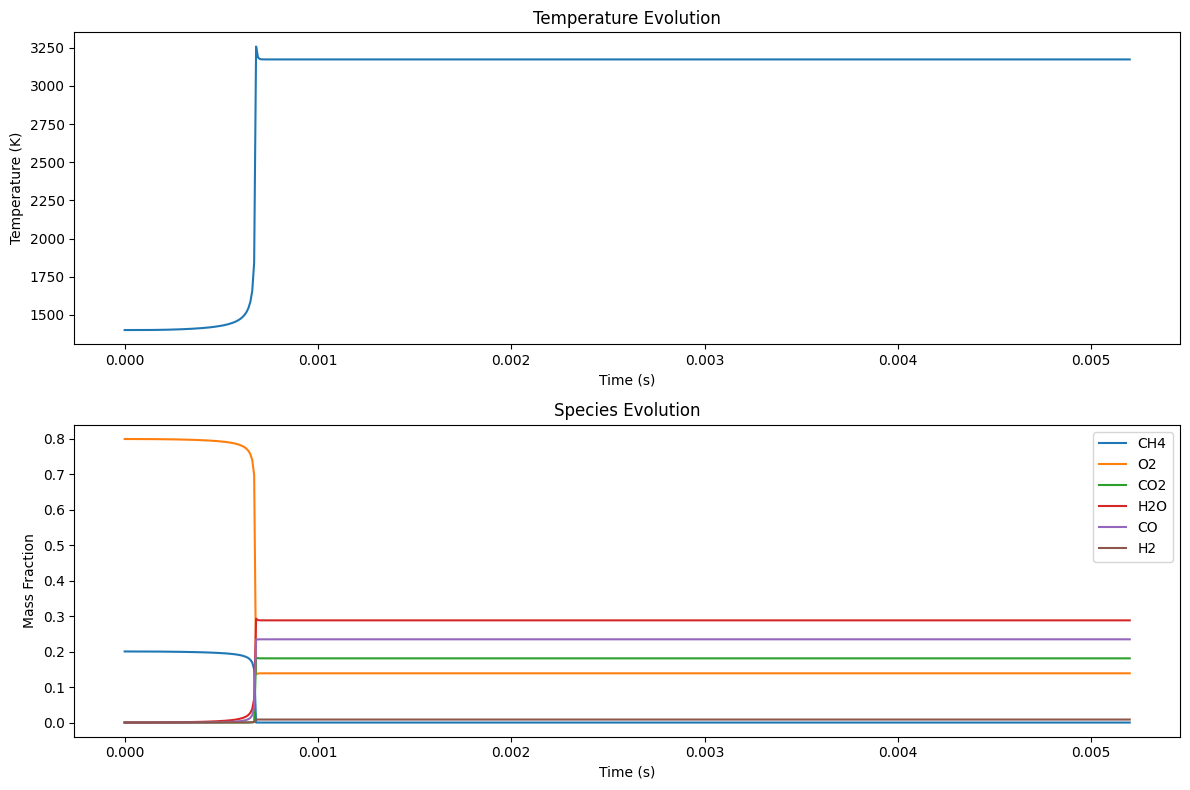

In [5]:
combustion_problem.plot_reference_solution()

In [6]:
# Define integrator methods
methods = [
('cvode_adams', 'CVODE ADAM'),
('cvode_bdf', 'CVODE BDF'),
('arkode_erk', 'ARKODE ERK'),
('cpp_rk23', 'C++ RK23')
]
methods_list = [method[0] for method in methods]
available_tables = {
            'HEUN_EULER_2_1_2': SundialsPy.arkode.ButcherTable.HEUN_EULER_2_1_2,
            'BOGACKI_SHAMPINE_4_2_3': SundialsPy.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3,
            'ARK324L2SA_ERK_4_2_3': SundialsPy.arkode.ButcherTable.ARK324L2SA_ERK_4_2_3,
            'ZONNEVELD_5_3_4': SundialsPy.arkode.ButcherTable.ZONNEVELD_5_3_4,
            'ARK548L2SA_ERK_8_4_5': SundialsPy.arkode.ButcherTable.ARK548L2SA_ERK_8_4_5,
            'ARK436L2SA_ERK_6_3_4': SundialsPy.arkode.ButcherTable.ARK436L2SA_ERK_6_3_4,
            'ARK437L2SA_ERK_7_3_4': SundialsPy.arkode.ButcherTable.ARK437L2SA_ERK_7_3_4,
            'ARK548L2SA_ERK_8_4_5': SundialsPy.arkode.ButcherTable.ARK548L2SA_ERK_8_4_5,
            'VERNER_8_5_6': SundialsPy.arkode.ButcherTable.VERNER_8_5_6,
            'FEHLBERG_13_7_8': SundialsPy.arkode.ButcherTable.FEHLBERG_13_7_8,
            'SDIRK_2_1_2': SundialsPy.arkode.ButcherTable.SDIRK_2_1_2,
            'BILLINGTON_3_3_2': SundialsPy.arkode.ButcherTable.BILLINGTON_3_3_2,
            'TRBDF2_3_3_2': SundialsPy.arkode.ButcherTable.TRBDF2_3_3_2,
            'KVAERNO_4_2_3': SundialsPy.arkode.ButcherTable.KVAERNO_4_2_3,
            'ARK324L2SA_DIRK_4_2_3': SundialsPy.arkode.ButcherTable.ARK324L2SA_DIRK_4_2_3,
            'CASH_5_2_4': SundialsPy.arkode.ButcherTable.CASH_5_2_4,
            'CASH_5_3_4': SundialsPy.arkode.ButcherTable.CASH_5_3_4,
            'SDIRK_5_3_4': SundialsPy.arkode.ButcherTable.SDIRK_5_3_4,
            'ARK436L2SA_DIRK_6_3_4': SundialsPy.arkode.ButcherTable.ARK436L2SA_DIRK_6_3_4,
            'ARK437L2SA_DIRK_7_3_4': SundialsPy.arkode.ButcherTable.ARK437L2SA_DIRK_7_3_4,
            'KVAERNO_7_4_5': SundialsPy.arkode.ButcherTable.KVAERNO_7_4_5,
            'ARK548L2SA_DIRK_8_4_5': SundialsPy.arkode.ButcherTable.ARK548L2SA_DIRK_8_4_5,
            'ARK324L2SA_ERK_4_2_3_DIRK_4_2_3': SundialsPy.arkode.ButcherTable.ARK324L2SA_ERK_4_2_3_DIRK_4_2_3,
            'ARK436L2SA_ERK_6_3_4_DIRK_6_3_4': SundialsPy.arkode.ButcherTable.ARK436L2SA_ERK_6_3_4_DIRK_6_3_4,
            'ARK437L2SA_ERK_7_3_4_DIRK_7_3_4': SundialsPy.arkode.ButcherTable.ARK437L2SA_ERK_7_3_4_DIRK_7_3_4,
            'ARK548L2SA_ERK_8_4_5_DIRK_8_4_5': SundialsPy.arkode.ButcherTable.ARK548L2SA_ERK_8_4_5_DIRK_8_4_5
        }

butcher_table_list = list(available_tables.values())

# Define tolerances
tolerances = [
(1e-6, 1e-8, 'Loose'),
(1e-12, 1e-14, 'Tight')
]

# Create results directory
results_dir = "combustion_results"
os.makedirs(results_dir, exist_ok=True)

In [7]:
int_config = SundialsIntegratorConfig(integrator_list=methods_list, tolerance_list=[(1e-6, 1e-8), (1e-12, 1e-14)], butcher_tables={'arkode_erk': butcher_table_list})

In [8]:
len(int_config.get_action_list())

56

In [9]:
int_config.get_action_list()

[('cvode_adams', 1e-06, 1e-08, None),
 ('cvode_adams', 1e-12, 1e-14, None),
 ('cvode_bdf', 1e-06, 1e-08, None),
 ('cvode_bdf', 1e-12, 1e-14, None),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.HEUN_EULER_2_1_2: 0>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.BOGACKI_SHAMPINE_4_2_3: 1>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.ARK324L2SA_ERK_4_2_3: 2>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.ZONNEVELD_5_3_4: 3>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.ARK548L2SA_ERK_8_4_5: 6>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.ARK436L2SA_ERK_6_3_4: 4>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.ARK437L2SA_ERK_7_3_4: 5>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.VERNER_8_5_6: 7>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.FEHLBERG_13_7_8: 8>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.SDIRK_2_1_2: 9>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.BILLINGTON_3_3_2: 10>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherTable.TRBDF2_3_3_2: 11>),
 ('arkode_erk', 1e-06, 1e-08, <ButcherT

In [10]:
combustion_problem.mech_file

'large_mechanism/ch4_53species.yaml'

In [11]:
integrator = SundialsChemicalIntegrator(
                    mechanism_file=combustion_problem.mech_file,
                    temperature=combustion_problem.temperature,
                    pressure=combustion_problem.pressure,
                    fuel=combustion_problem.fuel,
                    phi=combustion_problem.phi,
                    timestep=1e-6,  # Start with a small timestep
                    config=int_config
                )

In [12]:
integrator.reference_solution = combustion_problem.reference_solution

In [18]:
integrator.reset()

In [14]:
action_idx = -2
print(int_config.get_method_info(action_idx))
n_points = combustion_problem.num_steps
results = integrator.solve(end_time=combustion_problem.end_time, action_idx=action_idx)

{'method': 'cpp_rk23', 'rtol': 1e-12, 'atol': 1e-14, 'butcher_table': None, 'description': 'cpp_rk23 with rtol=1e-12, atol=1e-14, Butcher table=None'}
Solving with adaptive stepping to t=0.015
State changed to IGNITION at step 474
State changed to POSTIGNITION at step 3675
Stopping simulation at step 7351
Solution completed in 65.5408 seconds


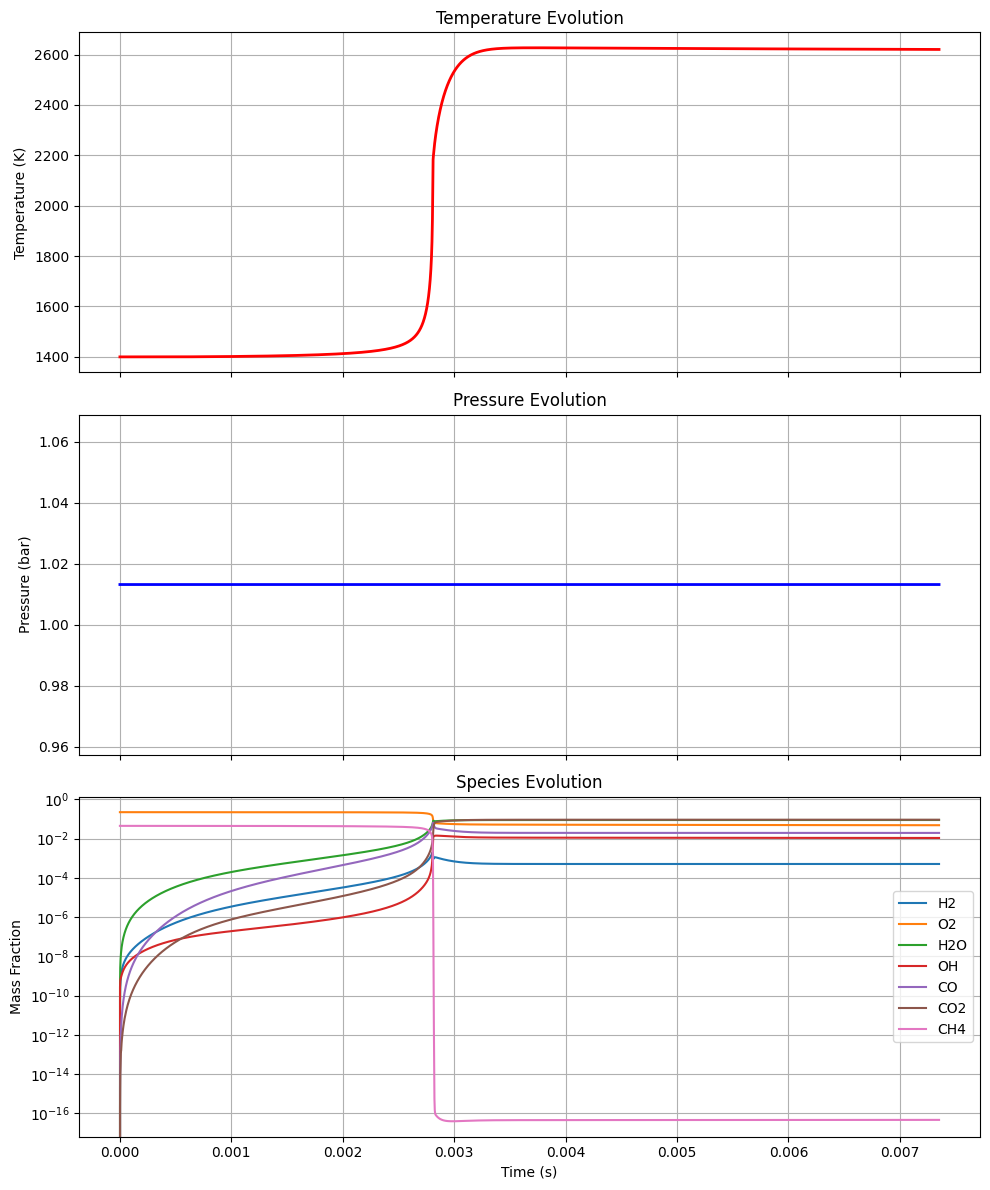

In [15]:
integrator.plot_results()

In [ ]:
fig = 

In [17]:
results['errors']

[np.float64(9.693314395597952e-08),
 np.float64(7.71046285596988e-06),
 np.float64(1.4093698816330935e-05),
 np.float64(1.8483255400103538e-05),
 np.float64(1.9771414040858915e-05),
 np.float64(1.6491138414065354e-05),
 np.float64(8.241856713442353e-06),
 np.float64(5.881161947551838e-06),
 np.float64(2.679424547624709e-05),
 np.float64(5.5572550191951287e-05),
 np.float64(9.139824035353517e-05),
 np.float64(0.00013806966921359187),
 np.float64(0.0001941689818033554),
 np.float64(0.0002617398485509348),
 np.float64(0.00034187527034956755),
 np.float64(0.0004354416898567637),
 np.float64(0.0005433383360914368),
 np.float64(0.0006663442760270755),
 np.float64(0.0008050545473697879),
 np.float64(0.0009598572572034891),
 np.float64(0.0011310067307794824),
 np.float64(0.0013188770935547156),
 np.float64(0.0015238820562654132),
 np.float64(0.001747176719950283),
 np.float64(0.0019888454941295874),
 np.float64(0.0022492991706304366),
 np.float64(0.002528979202519599),
 np.float64(0.0028285591

In [22]:
results.keys()

dict_keys(['times', 'states', 'temperatures', 'pressures', 'species_profiles', 'cpu_times', 'actions_taken', 'success_flags', 'errors', 'stages', 'stage_values'])